In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import DistilBertConfig, DistilBertTokenizer, TFDistilBertModel, pipeline
from sklearn.metrics import hamming_loss
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from wordcloud import WordCloud
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import zipfile

def load_dataset(zip_path, csv_file):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(csv_file) as f:
            df = pd.read_csv(f)
    return df

train_df = load_dataset('train.csv.zip', 'train.csv')
test_df = load_dataset('test.csv.zip', 'test.csv')
dev_df = load_dataset('dev.csv.zip', 'dev.csv')

texts_train = train_df['Description'].fillna(' ')
labels_train = train_df.drop(columns=['Description'])

texts_dev = dev_df['Description'].fillna(' ')
labels_dev = dev_df.drop(columns=['Description'])

texts_test = test_df['Description'].fillna(' ')


In [3]:
train_df.isnull().sum()

Description                          0
Commenting                           0
Ogling/Facial Expressions/Staring    0
Touching /Groping                    0
dtype: int64

In [4]:
test_df.isnull().sum()

Description                          0
Commenting                           0
Ogling/Facial Expressions/Staring    0
Touching /Groping                    0
dtype: int64

In [5]:
dev_df.isnull().sum()

Description                          0
Commenting                           0
Ogling/Facial Expressions/Staring    0
Touching /Groping                    0
dtype: int64

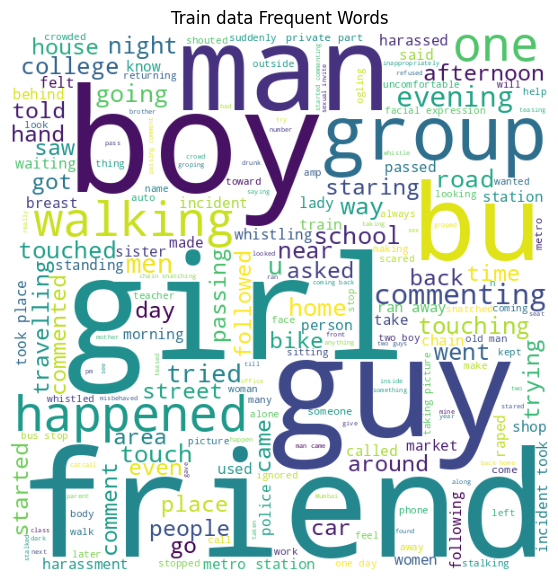

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
fig, (ax1) = plt.subplots(1, figsize = (7, 7))
wordcloud = WordCloud(background_color = 'white', width = 600, height = 600).generate(" ".join(texts_train))
ax1.set_title('{} data Frequent Words'.format('Train'))
ax1.imshow(wordcloud)
ax1.axis('off')
plt.show(ax1)

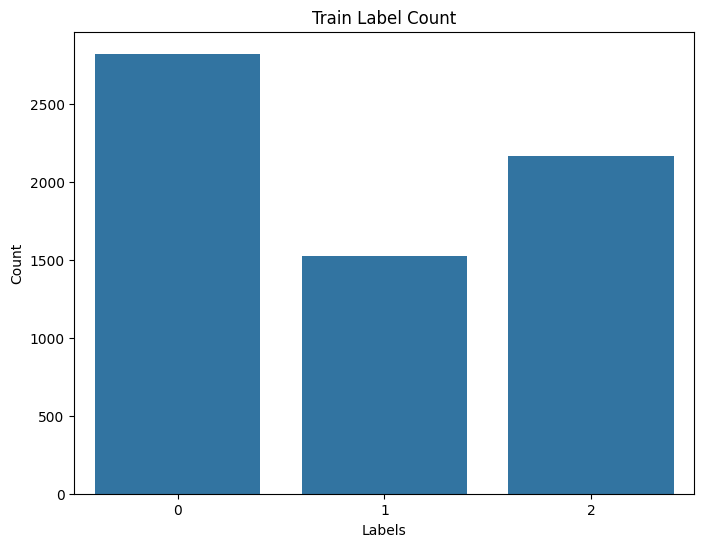

In [16]:
import matplotlib.pyplot as plt
import seaborn as sb
temp = []
cols = labels_train.columns
for col in cols:
    temp.append(labels_train[col][labels_train[col]==1].count())

plt.figure(figsize = (8, 6))
sb.barplot(temp)
plt.title('{} Label Count'.format('Train'))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(texts_train)

cols = labels_train.columns
for col in cols:
    filtered_texts = texts_train[labels_train[col] == 1]

    tfidf_matrix = vectorizer.transform(filtered_texts)

    avg_scores = np.mean(tfidf_matrix, axis=0)
    sorted_indices = np.argsort(avg_scores).flatten()[::-1]

    feature_names = vectorizer.get_feature_names_out()

    frequent_words = [feature_names[i] for i in sorted_indices[:10]]
    rare_words = [feature_names[i] for i in sorted_indices[-10:]]

    df = pd.DataFrame({'Frequent Words': frequent_words, 'Rare Words': rare_words[::-1]})

    print('|', col, '|')
    print('-' * (len(col) + 4))
    print(df)
    print()

| Commenting |
--------------
                                      Frequent Words  \
0  [[priest, focusing, flate, flatmate, flats, fl...   

                                          Rare Words  
0  [[priest, focusing, flate, flatmate, flats, fl...  

| Ogling/Facial Expressions/Staring |
-------------------------------------
                                      Frequent Words  \
0  [[indians, indirectly, indiranagar, screaming,...   

                                          Rare Words  
0  [[indians, indirectly, indiranagar, screaming,...  

| Touching /Groping |
---------------------
                                      Frequent Words  \
0  [[ganga, garage, gaps, gaon, gaodevi, gangrape...   

                                          Rare Words  
0  [[ganga, garage, gaps, gaon, gaodevi, gangrape...  



# Data Cleaning

In [88]:
import re
def clean(sentence):
  sent = sentence.replace('\\r', ' ')
  sent = sent.replace('\\n', ' ')
  sent = sent.replace('\\"', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  if bool(re.search(r'\d', sent)):
    sent = re.sub('[0-9]{5,}', '#####', sent)
    sent = re.sub('[0-9]{4}', '####', sent)
    sent = re.sub('[0-9]{3}', '###', sent)
    sent = re.sub('[0-9]{2}', '##', sent)
  sent = sent.lower().strip()
  return sent

In [10]:
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"didn't", "did not", phrase)
  phrase = re.sub(r"havn't", "have not", phrase)
  phrase = re.sub(r"hasn't", "has not", phrase)
  phrase = re.sub(r"can't", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [11]:
texts_train.apply(clean)
texts_train.apply(decontracted)
texts_test.apply(clean)
texts_test.apply(decontracted)
texts_dev.apply(clean)
texts_dev.apply(decontracted)

0      Buses approaching to this place is highly unsafe.
1                            a man was commenting at me.
2                                        in a share auto
3      I was coming out of a club at night with a few...
4      One of my friends was molested in the crowd. T...
                             ...                        
985    I was returning to my home riding a bicycle wh...
986    two boys on a bike commented and abused my fri...
987    During evening , a guy showed me a middle fing...
988    It was a evening time two very young boys were...
989     Tried to touch my breast with his elbow and hand
Name: Description, Length: 990, dtype: object

In [12]:
texts_train = texts_train.str.lower()
texts_dev = texts_dev.str.lower()
texts_test = texts_test.str.lower()

# Data Preprocessing

In [ ]:
!pip install gensim
import gensim.downloader as api

In [15]:
w2v_model = api.load('word2vec-google-news-300')
def w2v(X):
    words = list(w2v_model.key_to_index.keys())
    x = []
    for sentence in tqdm(X):
        vector = np.zeros(300)
        for word in sentence.split():
            if word in words:
                vector += w2v_model[word]
        x.append(vector)
    x = np.array(x)
    return x

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [16]:
train_x = w2v(texts_train)
dev_x = w2v(texts_dev)
test_x = w2v(texts_test)

100%|██████████| 1701/1701 [06:41<00:00,  4.23it/s]


In [18]:
tab = PrettyTable()
tab.field_names = ['Compliment Hamming Loss', 'C']

values = np.random.uniform(0, 10, 10)
best_score = 0
best_value = None

for c in tqdm(values):
    model = MultiOutputClassifier(LogisticRegression(C=c, class_weight='balanced'))
    model.fit(train_x, labels_train)
    score = 1 - hamming_loss(labels_dev, model.predict(dev_x))

    if score > best_score:
        best_score = score
        best_value = c

    tab.add_row([score, c])

model = MultiOutputClassifier(LogisticRegression(C=best_value, class_weight='balanced'))
model.fit(train_x, labels_train)

print(tab)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


+-------------------------+---------------------+
| Compliment Hamming Loss |          C          |
+-------------------------+---------------------+
|    0.7582491582491583   |  7.799831724941563  |
|    0.7579124579124579   |  8.088234440142664  |
|    0.7612794612794613   |  6.164721786486458  |
|    0.7582491582491583   |  5.376804706513814  |
|    0.7595959595959596   | 0.29113076244376423 |
|    0.7602693602693602   |  0.8972517398827629 |
|    0.7602693602693602   |  2.6274283160272907 |
|    0.7595959595959596   |   8.94320635444059  |
|    0.7589225589225589   |  8.972388327780184  |
|    0.7606060606060606   |  2.1492166304628144 |
+-------------------------+---------------------+


In [21]:
score

0.7606060606060606

In [ ]:
!!pip install shap

In [40]:
import shap

shap_values_list = []

for idx, estimator in enumerate(model.estimators_):

    explainer = shap.Explainer(estimator, train_x[:100])

    shap_values = explainer(dev_x[:100])

    shap_values_list.append(shap_values)

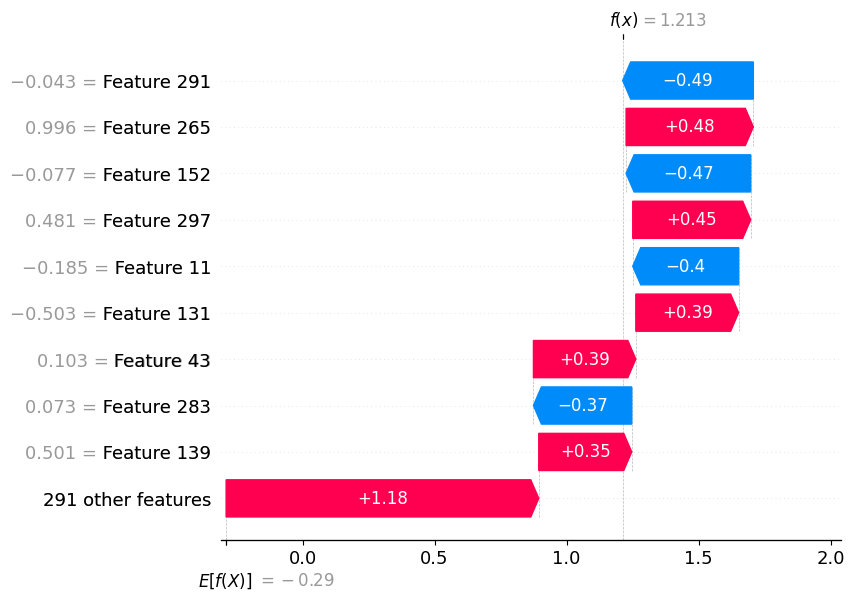

In [39]:
shap.plots.waterfall(shap_values_list[0][0])

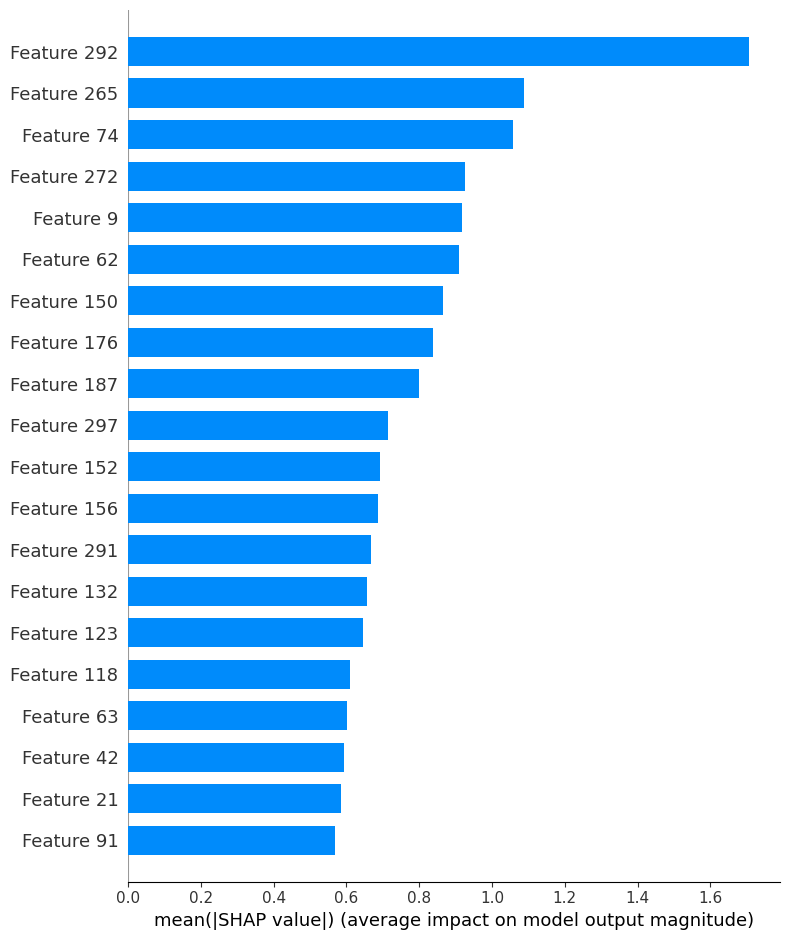

In [41]:
aggregate_shap_values = np.sum([shap_values.values for shap_values in shap_values_list], axis=0)

shap.summary_plot(aggregate_shap_values, dev_x[:100], plot_type="bar")

In [151]:
test_df['Description'].apply(clean)
test_df['Description'].apply(decontracted)
texts_to_predict = test_df['Description'].fillna(' ').str.lower()
texts_to_predict = vectorizer.transform(texts_to_predict)

predictions = model.predict(texts_to_predict)
predictions_df = pd.DataFrame(predictions, columns=['pred_commenting', 'pred_ogling', 'pred_touching'])
predicted_data = pd.concat([test_df, predictions_df], axis=1)

In [152]:
predicted_data

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping,pred_commenting,pred_ogling,pred_touching
0,"During morning, a woman was walking by and thi...",1,1,0,1,0,0
1,A man tried to brush his penis off of a woman'...,0,0,1,0,1,1
2,This happened to a fellow passenger of mine tr...,0,1,0,0,0,0
3,ogling,0,1,0,0,1,0
4,When I was returning my home after finishing m...,0,0,1,0,0,1
...,...,...,...,...,...,...,...
1696,obscene comments and staring,1,0,0,1,1,0
1697,I was going with my friend In metro in morning...,1,0,1,1,0,1
1698,A person tried to grab me when I was walkng in...,0,0,1,0,0,1
1699,few bad people touched my private parts in Ran...,0,0,1,0,0,1


In [153]:
from sklearn.metrics import accuracy_score

accuracy1 = accuracy_score(predicted_data.Commenting, predicted_data.pred_commenting)
accuracy2 = accuracy_score(predicted_data['Ogling/Facial Expressions/Staring'], predicted_data.pred_ogling)
accuracy3 = accuracy_score(predicted_data['Touching /Groping'], predicted_data.pred_touching)

In [154]:
accuracy1

0.7860082304526749

In [155]:
accuracy2

0.7589653145208701

In [156]:
accuracy3

0.8542034097589654

In [157]:
(accuracy1+accuracy2+accuracy3)/3

0.7997256515775035

In [158]:
predicted_data = predicted_data.drop(['Commenting', 'Ogling/Facial Expressions/Staring', 'Touching /Groping'], axis=1)

In [159]:
predicted_data = predicted_data.drop(['Description'], axis=1)

In [160]:
predicted_data.to_csv('predicted_data.csv', index=False)

In [172]:
shap_values_array = shap_values.values

shap_values_first_instance = shap_values_array[0]

explanations_df = pd.DataFrame([shap_values_first_instance], columns=[f'Feature_{i}' for i in range(shap_values_first_instance.size)])


In [173]:
explanations_df

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_290,Feature_291,Feature_292,Feature_293,Feature_294,Feature_295,Feature_296,Feature_297,Feature_298,Feature_299
0,0.014996,0.057375,0.022544,-0.300823,-0.021287,-0.202709,0.061114,0.029584,-0.070736,0.80356,...,0.055568,0.168213,0.979092,-0.010205,0.205085,0.102949,0.134015,0.502136,-0.036789,-0.000288


In [174]:
explanations_df.to_csv('explanations.csv', index=False)